In [1]:
import pandas as pd
import csv
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

In [2]:
# Read weather data
wdf = pd.read_csv("D:/SMUMSDS/TimeSeries/Final Project/weather.csv")

In [3]:
# Calculate daily average temperature and humidity
weather = wdf.groupby(['month', 'day']).agg(avg_temp=('temp', 'mean'), avg_humidity=('humidity', 'mean')).reset_index()

In [4]:
# Read flight data
airdf = pd.read_csv("D:/SMUMSDS/TimeSeries/Final Project/ModAirDelay2018V2.csv")

In [5]:
# Extract year, month, and day from the FL_DATE column
airdf2 = airdf['FL_DATE'].str.split('-', expand=True)
airdf2.columns = ['year', 'month', 'day']
airdf2 = pd.concat([airdf2, airdf.iloc[:,1:]], axis=1)

In [6]:
# Convert year, month, and day to integers
airdf2['year'] = airdf2['year'].astype(int)
airdf2['month'] = airdf2['month'].astype(int)
airdf2['day'] = airdf2['day'].astype(int)

In [7]:
# Merge weather and flight data
df = pd.merge(airdf2, weather, how='left', on=['month', 'day'])

In [8]:
# Save the modified DataFrame back to a CSV file
df.to_csv("D:/SMUMSDS/TimeSeries/Final Project/ModAirDelay2018V3.csv", index=False, quoting=csv.QUOTE_NONNUMERIC)

In [9]:
# Display the first 5 rows of the modified DataFrame
print(df.head())

# Display the shape of the modified DataFrame
print(df.shape)

# Display the number of missing values in each column of the modified DataFrame
print(df.isnull().sum())

   year  month  day OP_CARRIER  OP_CARRIER_FL_NUM ORIGIN DEST  CRS_DEP_TIME  \
0  2018      1    1         OO               3309    DAL  PDX          1929   
1  2018      1    1         OO               3320    DAL  LGA           615   
2  2018      1    1         OO               3322    DAL  LGA          1027   
3  2018      1    1         OO               3324    DAL  LGA          1235   
4  2018      1    1         OO               3326    DAL  LGA          1705   

   DEP_TIME  DEP_DELAY  avg_temp  avg_humidity  
0    1914.0      -15.0   23.0675     46.166667  
1     621.0        6.0   23.0675     46.166667  
2    1021.0       -6.0   23.0675     46.166667  
3    1230.0       -5.0   23.0675     46.166667  
4    1653.0      -12.0   23.0675     46.166667  
(70995, 12)
year                   0
month                  0
day                    0
OP_CARRIER             0
OP_CARRIER_FL_NUM      0
ORIGIN                 0
DEST                   0
CRS_DEP_TIME           0
DEP_TIME           

In [10]:
# Find the P and Q values for the ARIMA model
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt   


In [11]:
# Create time series data
ts = df.groupby(['year', 'month', 'day']).agg(avg_temp=('avg_temp', 'mean'), avg_humidity=('avg_humidity', 'mean'), avg_dep_delay=('DEP_DELAY', 'mean')).reset_index()

# Display the first 5 rows of the modified DataFrame
print(ts.head())

   year  month  day   avg_temp  avg_humidity  avg_dep_delay
0  2018      1    1  23.067500     46.166667      24.428571
1  2018      1    2  24.285000     48.208333      15.800000
2  2018      1    3  29.402917     46.291667      11.839196
3  2018      1    4  36.949167     52.041667       6.827225
4  2018      1    5  44.342500     42.958333       2.798995


In [12]:
# Create a function to plot the time series, ACF, and PACF
def plot_series(ts, title, xlab, ylab, start, end, lags=None):
    fig, ax = plt.subplots(3, 1, figsize=(12, 12))
    ts[start:end].plot(ax=ax[0])
    ax[0].set_title(title)
    ax[0].set_xlabel(xlab)
    ax[0].set_ylabel(ylab)
    plot_acf(ts, ax=ax[1], lags=lags)
    plot_pacf(ts, ax=ax[2], lags=lags)
    plt.show()

In [13]:
# Create a function to test for stationarity
def test_stationarity(series, title, xlab, ylab, start, end, lags=None):
    
    # Plot the time series, ACF, and PACF
    plot_series(series, title, xlab, ylab, start, end, lags)
    
    # Perform the Augmented Dickey-Fuller test
    adf_test = adfuller(series)
    
    # Extract and display test results in a user friendly manner
    adf_output = pd.Series(adf_test[0:4], index=['Test Statistic', 'p-value', '# Lags Used', '# Observations Used'])
    print(adf_output)
    print('\nCritical Values:')
    for key, value in adf_test[4].items():
        print(f'{key}: {value}')

D:\Anaconda\lib\site-packages\matplotlib\axes\_base.py:2480: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
D:\Anaconda\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


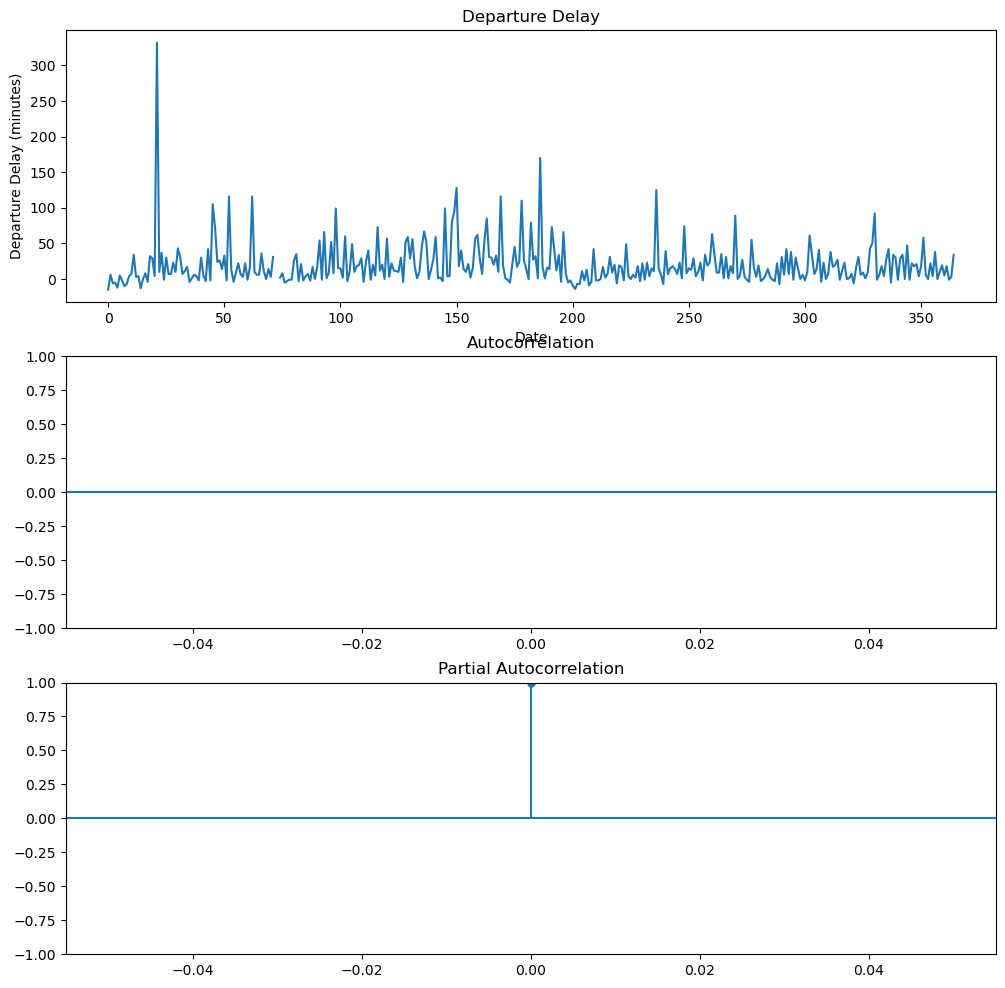

MissingDataError: exog contains inf or nans

In [14]:
# Test for stationarity
test_stationarity(df['DEP_DELAY'], 'Departure Delay', 'Date', 'Departure Delay (minutes)', 0, 365, 30)

In [15]:
# Create a function to difference the series
def difference(ts, interval=1):
    diff = list()
    for i in range(interval, len(ts)):
        value = ts[i] - ts[i - interval]
        diff.append(value)
    return pd.Series(diff)

In [ ]:
# Create a function to invert differenced values
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]